In [1]:
# Package imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, f1_score, accuracy_score

In [2]:
def read_data():
    df = pd.DataFrame()
    dirs = os.listdir('data')
    for folder in dirs:
        if folder != '.DS_Store':
            filenames = glob.glob(os.path.join('data', folder, '*/*.txt'), recursive = True)
            for filename in filenames:
                if ('MANIFEST.txt' not in filename) and ('annotations.txt' not in filename):
                    temp_df = pd.read_csv(filename, '\t')
                    row_dict = {'cancer': folder}
                    for index, row in temp_df.iterrows():
                        row_dict[row['miRNA_ID']] = row['reads_per_million_miRNA_mapped']

                    df = df.append(row_dict, ignore_index = True)
    
    le = preprocessing.LabelEncoder()
    df['cancer_code'] = le.fit_transform(df['cancer'])
    
    df.to_csv('data_cleaned.csv', index=False)


In [3]:
def load_data():
    return pd.read_csv('data_cleaned.csv')

In [4]:
def random_forest():
    pass

In [5]:
'''
Performs 5-fold CV over a range of hyperparameters and returns the best-performing SVM model
'''
def svm(X_train, y_train):
    params = {'kernel':('linear', 'poly', 'rbf'), 'C':[0.01, 0.1, 1], 'degree': [2,3], 'gamma': [0.1, 0.01, 0.001, 0.0001], 'cache_size': [1000]}
    print('Grid Search on SVM...')
    svc = SVC()
    clf = GridSearchCV(svc, params)
    clf.fit(X_train, y_train)
    
    results_df = pd.DataFrame(clf.cv_results_)
    results_df.to_csv('svm_cv_results.csv')
    
    print('Best SVM Params (score %f):' % clf.best_score_)
    print(clf.best_params_)
    print()
    
    return clf.best_estimator_

In [6]:
'''
Calculates accuracy, f1 score, and a confusion matrix for the given model and (scaled) evaluation data.
Params:
    model: the model to be evaluated
    X_eval: feature-scaled evaluation set
    y_eval: evaluation labels
    name: string of the model name (used for graph titles)
'''
def calc_stats(model, X_eval, y_eval, name):
    print('Evaluation of %s Model:' % name)
    #results
    preds = model.predict(X_eval)
    f_score = f1_score(y_eval, preds, average='micro')
    acc_score = accuracy_score(y_eval, preds)
    print('%s: F1 = %f, accuracy = %f' % (name, f_score, acc_score))
    
    #confusion matrix
    plot_confusion_matrix(model, X_eval, y_eval)
    plt.title('Confusion Matrix for {} Model'.format(name))
    plt.savefig('imgs/{}_confusion.png'.format(name))
    plt.show()
    
    print()

In [7]:
def main():
    df = load_data()
    
    #split into train, test, and evaluation sets
    X = df.drop(columns=['cancer', 'cancer_code'])
    y = df['cancer_code']
    X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)
    #X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=2, stratify=y_train)
    
    #scale data
    min_max_scalar = preprocessing.MinMaxScaler()
    X_train_scaled = min_max_scalar.fit_transform(X_train)
    #min_max_scalar = preprocessing.MinMaxScaler()
    #X_test_scaled = min_max_scalar.fit_transform(X_test)
    min_max_scalar = preprocessing.MinMaxScaler()
    X_eval_scaled = min_max_scalar.fit_transform(X_eval)
    
    svm_model = svm(X_train_scaled, y_train)
    
    calc_stats(svm_model, X_eval_scaled, y_eval, 'SVM')

Grid Search on SVM...
Best SVM Params (score 0.960703):
{'C': 0.1, 'cache_size': 1000, 'degree': 2, 'gamma': 0.1, 'kernel': 'linear'}

Evaluation of SVM Model:
SVM: F1 = 0.974093, accuracy = 0.974093


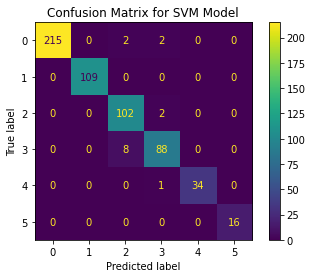

In [8]:
main()